<img src="https://www.aepia.org/wp-content/uploads/2022/04/logo-aepia.png" width="200"/>

<img src="https://i1.rgstatic.net/ii/lab.file/AS%3A608742152355841%401522146847661_xl" width="300"/>

<img src="https://www.upo.es/cms1/export/sites/upo/comunicacion/imagenes/mic-upo-descargas/Marca-UPO-Horizontal.png" width="200"/>



# **Deep Learning: Image classification**
## Escuela de verano de Inteligencia Artificial 2023
#### José Fco. Torres Maldonado

jftormal@upo.es | datalab.upo.es/torres



---



In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from imutils import paths
import keras as keras
import os
import cv2
import zipfile
from sklearn.metrics import confusion_matrix

## 1. Dataset: 25000 fotografías de perros y gatos

Formato .zip<br/>
Nombradas como: cat.XXXX.jpg y dog.XXXX.jpg

Importar el archivo zip y extraerlo

In [2]:
zip = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/EVIA2023/dataset.zip", 'r')
zip.extractall("/")
zip.close()

Mostrar información y verificar que se han cargado de forma correcta

In [3]:
print("Número de imágenes: ", len(os.listdir("/dataset")))
print("Contenido: ", os.listdir("/dataset"))

Número de imágenes:  25000
Contenido:  ['cat.1516.jpg', 'dog.9768.jpg', 'cat.4659.jpg', 'cat.8262.jpg', 'dog.230.jpg', 'dog.9075.jpg', 'cat.8190.jpg', 'cat.2108.jpg', 'cat.11897.jpg', 'dog.1334.jpg', 'cat.11713.jpg', 'cat.508.jpg', 'cat.6619.jpg', 'cat.10387.jpg', 'dog.10853.jpg', 'dog.10995.jpg', 'dog.1347.jpg', 'dog.8607.jpg', 'cat.8634.jpg', 'dog.5245.jpg', 'dog.7788.jpg', 'cat.2687.jpg', 'dog.11264.jpg', 'cat.10763.jpg', 'cat.5573.jpg', 'cat.6121.jpg', 'cat.8198.jpg', 'cat.10046.jpg', 'dog.10166.jpg', 'cat.1439.jpg', 'cat.5755.jpg', 'dog.9507.jpg', 'dog.11252.jpg', 'dog.2156.jpg', 'dog.3344.jpg', 'dog.5414.jpg', 'cat.6242.jpg', 'dog.971.jpg', 'dog.10233.jpg', 'dog.3688.jpg', 'dog.6594.jpg', 'cat.6038.jpg', 'dog.1200.jpg', 'cat.770.jpg', 'cat.5730.jpg', 'cat.3689.jpg', 'cat.9636.jpg', 'cat.3813.jpg', 'dog.10710.jpg', 'cat.5827.jpg', 'dog.7317.jpg', 'cat.1005.jpg', 'dog.917.jpg', 'dog.10143.jpg', 'cat.9812.jpg', 'cat.5288.jpg', 'cat.11348.jpg', 'cat.7419.jpg', 'dog.3625.jpg', 'dog.60

Mostrar una imagen de ejemplo, observando cómo se puede cambiar el espacio de color y reescalar la imagen a otra resolución (necesario para el análisis)

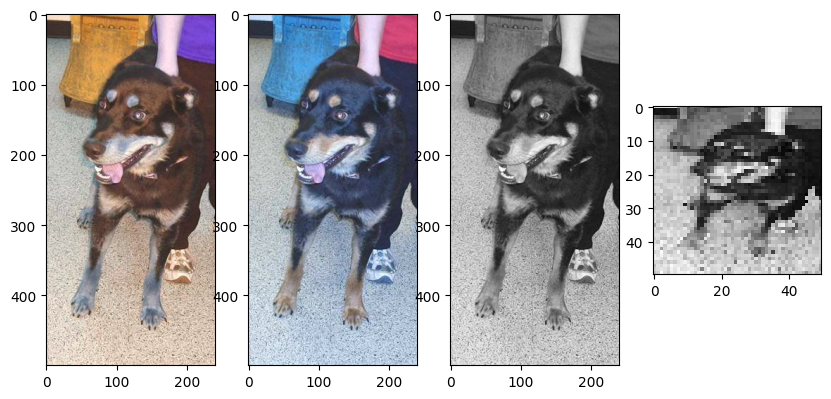

In [4]:
img = cv2.imread('/dataset/dog.7182.jpg')

imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imggray = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2GRAY)
img50x50 = cv2.resize(imggray, (50, 50))

fig, axs = plt.subplots(1, 4, figsize=(10, 10))
axs[0].imshow(img)
axs[1].imshow(imgrgb)
axs[2].imshow(imggray, cmap='gray')
axs[3].imshow(img50x50, cmap="gray")

plt.show()

## 2. Preprocesado

Definir una función que unifique el tamaño de todas las imágenes y que la devuelva como un vector

In [5]:
def image_as_vector(img, tam=(50,50)):
    img = cv2.resize(img, tam)
    return img.flatten()

Definir variables para almacenar los datos por un lado y las etiquetas por otro.

Almacenar además todo el listado de las imágenes

In [6]:
data = []
labels = []

listaImagenes = list(paths.list_images('/dataset'))
print(listaImagenes[0:5])

['/dataset/cat.1516.jpg', '/dataset/dog.9768.jpg', '/dataset/cat.4659.jpg', '/dataset/cat.8262.jpg', '/dataset/dog.230.jpg']


Para cada imagen de las imágenes disponibles:
- Se obtiene la etiqueta del nombre y se almacena en el vector labels.
- Se cambia el tamaño y se almacena como vector.
- En el vector data se añade el vector que tiene la información de la imagen.con la ruta.


In [7]:
for (i, imgpath) in enumerate(listaImagenes):
    img = cv2.imread(imgpath)
    label = imgpath.split(os.path.sep)[-1].split(".")[0]
    features = image_as_vector(img)
    data.append((features, imgpath))
    labels.append(label)

Mostrar información

In [8]:
print("Total de imágenes:",len(data))
print("Registro:", data[0])
print("Imagen:", data[0][0])
print("Tamaño de cada imagen:", len(data[0][0])) #Equivale a 50x50x3 canales
print("Ruta:", data[0][1])
print("Etiqueta:", labels[0])

Total de imágenes: 25000
Registro: (array([201, 196, 193, ..., 161, 163, 164], dtype=uint8), '/dataset/cat.1516.jpg')
Imagen: [201 196 193 ... 161 163 164]
Tamaño de cada imagen: 7500
Ruta: /dataset/cat.1516.jpg
Etiqueta: cat


Separamos los datos de las imágenes de las rutas en dos variables diferentes

In [9]:
imagesdata = [dat[0] for dat in data]
imagespaths = [dat[1] for dat in data]

print(imagesdata[0])
print(imagespaths[0])

[201 196 193 ... 161 163 164]
/dataset/cat.1516.jpg


Crear una codificación ONE-HOT para las etiquetas, donde para cada imagen se tiene una etiqueta que puede valer:

- [0, 1] (será un perro) 
- [1, 0] (será un gato)

In [10]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

imgdata = np.array(imagesdata) / 255.0
labels = np_utils.to_categorical(labels,2)

In [11]:
print("Imagen de ejemplo:",imgdata[0])
print("Etiqueta de ejemplo:",labels[0])

Imagen de ejemplo: [0.78823529 0.76862745 0.75686275 ... 0.63137255 0.63921569 0.64313725]
Etiqueta de ejemplo: [1. 0.]


Separar datos en training y test

In [12]:
(X_train, X_test, y_train, y_test, trainingpaths, testpaths) = train_test_split(imgdata, labels, imagespaths, test_size=0.30, random_state=42)

In [13]:
print("Tamaño del training:", len(X_train))
print("Tamaño del test:", len(X_test))

Tamaño del training: 17500
Tamaño del test: 7500


## 3. Modelos Deep Learning

### 3.1 Multilayer Perceptron (MLP)

Definir arquitectura de la red

In [14]:
mlpmodel = keras.Sequential()
mlpmodel.add(keras.layers.Dense(32, input_dim=7500, activation="softmax"))
mlpmodel.add(keras.layers.Dense(2, activation="softmax"))
sgd = keras.optimizers.SGD(lr=0.01)
mlpmodel.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
mlphistory = mlpmodel.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
137/137 [==============================] - 3s 13ms/step - loss: 0.6935 - accuracy: 0.4869
Epoch 2/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6929 - accuracy: 0.5156
Epoch 3/10
137/137 [==============================] - 1s 9ms/step - loss: 0.6925 - accuracy: 0.5278
Epoch 4/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6919 - accuracy: 0.5391
Epoch 5/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6906 - accuracy: 0.5553
Epoch 6/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5621
Epoch 7/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6856 - accuracy: 0.5645
Epoch 8/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6837 - accuracy: 0.5698
Epoch 9/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6820 - accuracy: 0.5716
Epoch 10/10
137/137 [==============================] - 1s 8ms/step - loss: 0.6803 - accuracy: 0.57

Mostrar sumario del modelo y la gráfica de la convergencia

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                240032    
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 240,098
Trainable params: 240,098
Non-trainable params: 0
_________________________________________________________________


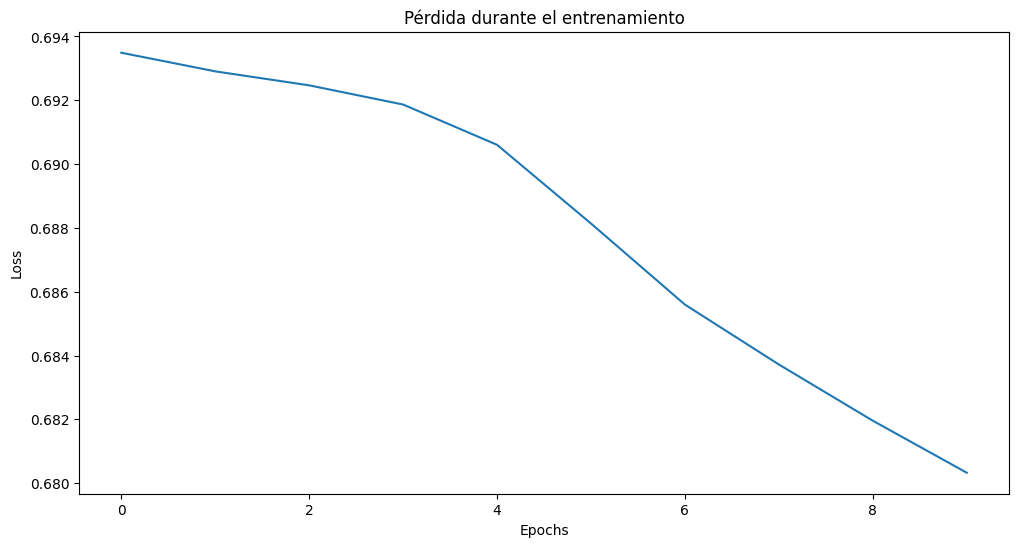

In [16]:
mlpmodel.summary()

# Gráfica de la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(mlphistory.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluar el modelo

In [17]:
(loss, accuracy) = mlpmodel.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy*100))

59/59 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5892
loss=0.6802, accuracy: 58.9200%


Predecir el modelo con el conjunto de test.

Para cada predicción habrá dos neuronas. La que tenga la activación mas alta es la que se ha predicho, por lo que hay que redondearla y quedarse con la mayor.

In [18]:
probabilities = mlpmodel.predict(X_test)
predictions = np.round(np.argmax(probabilities, axis=1)).astype(int)

235/235 [==============================] - 1s 2ms/step


En los datos reales, tenemos que quedarnos con el índice del vector que tenga activado el valor 1

In [19]:
# y_test contiene por cada imagen un vector [X,Y]. Si X vale 1 -> gato; si Y vale 1 -> perro. 
#Esta línea se queda con el índice para saber si es clase 0 (gato) o clase 1 (perro). 
#codificación ONE-HOT
real = np.argmax(y_test, axis=1) 

## Análisis de las predicciones

Función para mostrar resultado

In [20]:
def mostrar_resultado(idImagen):
    clase_real = "gato" if real[idImagen] == 0 else "perro"
    clase_predicha = "gato" if predictions[idImagen] == 0 else "perro"
    rutabase = "/dataset"
    fullpath = testpaths[idImagen]
    image = cv2.imread(fullpath)
    imgrgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imgrgb)
    plt.axis('off')
    plt.show()
    print("CLASE REAL: \t", clase_real)
    print("CLASE PREDICHA:\t", clase_predicha)
    return fullpath

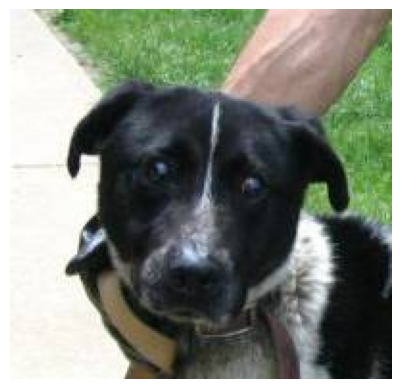

CLASE REAL: 	 perro
CLASE PREDICHA:	 perro


'/dataset/dog.11247.jpg'

In [22]:
mostrar_resultado(400)

Cálculo de métricas

In [23]:
# Calcular la exactitud (accuracy)
accuracy = accuracy_score(real, predictions)
print("ACC (%): ", accuracy*100)

# Calcular la precisión (precision)
precision = precision_score(real, predictions)
print("precision : ", precision)

# Calcular la exhaustividad (recall)
recall = recall_score(real, predictions)
print("recall : ", recall)

# Calcular la puntuación F1
f1 = f1_score(real, predictions)
print("F1 : ", f1)

# Calcular el área bajo la curva ROC (AUC-ROC)
auc_roc = roc_auc_score(real, predictions)
print("AUC : ", auc_roc)

# Matriz de confusión
cm = confusion_matrix(real, predictions)
print(cm)

ACC (%):  58.919999999999995
precision :  0.565695792880259
recall :  0.7105691056910569
F1 :  0.6299099099099099
AUC :  0.5911113244990718
[[1797 2013]
 [1068 2622]]
